<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Installation" data-toc-modified-id="Installation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Installation</a></span></li><li><span><a href="#Examples-of-usage-of-solve_ivp" data-toc-modified-id="Examples-of-usage-of-solve_ivp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Examples of usage of solve_ivp</a></span><ul class="toc-item"><li><span><a href="#1.-Restricted-three-body-problem" data-toc-modified-id="1.-Restricted-three-body-problem-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>1. Restricted three body problem</a></span></li><li><span><a href="#2.-Bouncing-ball" data-toc-modified-id="2.-Bouncing-ball-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2. Bouncing ball</a></span></li><li><span><a href="#3.-Van-der-Pol-oscillator" data-toc-modified-id="3.-Van-der-Pol-oscillator-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>3. Van der Pol oscillator</a></span></li></ul></li></ul></div>

# Installation

    git clone https://github.com/phaustin/eos_integrate.git
    cd eos_integrate
    pip install .

# Examples of usage of solve_ivp

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from eos_integrate import solve_ivp, DenseOutput

## 1. Restricted three body problem

The formulation is taken from an introductory chapter to Runge-Kutta methods in "Solving Ordinary Differential Equations I". The system of differential equations describes the 
motion of a body with a neglible mass in a gravitational field of two bodies with masses $\mu$ and $\nu = 1 - \mu$.

$$
y_1'' = y_1 + 2 y_2' - \nu \frac{y_1 + \mu}{D_1} - \mu \frac{y_1 - \mu'}{D_2} \\
y_2'' = y_2 - 2 y_1' - \nu \frac{y_2}{D_1} - \mu \frac{y_2}{D_2} \\
D_1 = ((y_1 + \mu)^2 + y_2^2)^{3/2}, \quad D_2 = ((y_1 - \nu)^2 + y_2^2)^{3/2} \\
\mu = 0.012277471
$$

The initial values are picked such that the solution is periodic with period $x_{end}$:
$$
y_1(0) = 0.994, y_1′(0) = 0, y_2(0) = 0 \\
y_2′(0) = −2.00158510637908252240537862224 \\
x_{end} = 17.0652165601579625588917206249
$$

It is straightforward to rewrite this systems as another first order system. We define the constants and evaluation of the system right-hand side:

In [3]:
mu = 0.0122771
nu = 1 - mu

a = 0
b = 17.0652165601579625588917206249
ya = [0.994, 0, 0, -2.00158510637908252240537862224]

In [4]:
def fun(x, y):
    D1 = ((y[0] + mu)**2 + y[1]**2) ** 1.5
    D2 = ((y[0] - nu)**2 + y[1]**2) ** 1.5

    return [
        y[2],
        y[3],
        y[0] + 2 * y[3] - nu * (y[0] + mu) / D1 - mu * (y[0] - nu) / D2,
        y[1] - 2 * y[2] - nu * y[1] / D1 - mu * y[1] / D2
    ]

The ODE is integrated by a single call:

In [5]:
res = solve_ivp(fun, [a, b], ya, rtol=1e-3, dense_output=True, method='RK45')
type(res)

eos_integrate._ivp.ivp.OdeResult

The function `solve_ivp` provides a continuous solution with the *same accuracy* as underlying method. Here we use is to produce a smooth plot with the compued trajectory.

In [6]:
xp = np.linspace(a, b, 500)
yp = res.sol(xp)

In [7]:
help(res.sol)

Help on OdeSolution in module eos_integrate._ivp.common object:

class OdeSolution(builtins.object)
 |  Continuous ODE solution.
 |  
 |  It is organized as a collection of `DenseOutput` objects which represent
 |  local interpolants. It provides an algorithm to select a right interpolant
 |  for each given point.
 |  
 |  The interpolants cover the range between `t_min` and `t_max` (see
 |  Attributes below). Evaluation outside this interval is not forbidden, but
 |  the accuracy is not guaranteed.
 |  
 |  When evaluating at a breakpoint (one of the values in `ts`) a segment with
 |  the lower index is selected.
 |  
 |  Parameters
 |  ----------
 |  ts : array_like, shape (n_segments + 1,)
 |      Time instants between which local interpolants are defined. Must
 |      be strictly increasing or decreasing (zero segment with two points is
 |      also allowed).
 |  interpolants : list of DenseOutput with n_segments elements
 |      Local interpolants. An i-th interpolant is assumed t

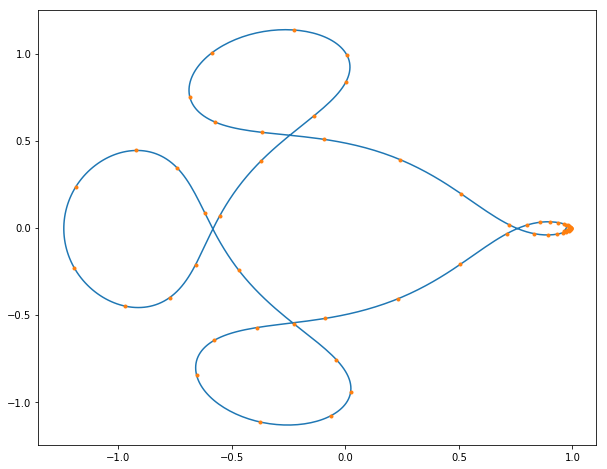

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(yp[0], yp[1], '-')
plt.plot(res.y[0], res.y[1], '.')

We see that at some regions the solver takes quite large steps, but an accurate solution is available at all points nevertheless.

## 2. Bouncing ball

This example illustrates event detection capabilities. The problem is very simple: a ball bounces from the ground and loses some fraction of its vertical velocity.

Define constants.

In [9]:
g = -9.81  # Gravity.
alpha = 0.8  # Ratio of preserved velocity.
v_hor = 50  # Horizontal velocity.
n_bounces = 10  # Number of bounces.

Define the system right-hand side:

In [10]:
def fun(x, y):
    return [v_hor, y[2], g]

Define the bounce event:

In [11]:
def bounce(t, y):
    return y[1]

bounce.terminal = True  # This event is terminating.
bounce.direction = -1  # Detected when y[1] is decreasing.

The solver runs until the bounce event is detected and then gets restarted with a new value of the vertical velocity.

In [12]:
ya = [0, 0, 100]  # Start at (0, 0) and with the vertical velocity of 10.


sol_smooth=[]
for i in range(n_bounces):
    print('bounce number: ',i)
    # Use a 3-rd order Runge-Kutta method.
    # Integration interval is not relevant. 
    start,stop=0,1500
    res = solve_ivp(fun,[start,stop] ,ya,t_eval=None, events=bounce,dense_output=True, method='RK45')
    tpoints=np.linspace(res.t[0],res.t[-1],50)
    print(f'completed solution {res.y}\n\n')
    smooth_y=res.sol(tpoints)
    sol_smooth.append(smooth_y)
    ya = res.y[:, -1].copy()
    ya[2] *= -alpha

bounce number:  0
completed solution [[  0.00000000e+00   4.47209123e-04   4.91930036e-03   4.96402127e-02
    4.96849336e-01   4.96894057e+00   4.96898529e+01   4.96898976e+02
    1.01936799e+03]
 [  0.00000000e+00   8.94417854e-04   9.83855324e-03   9.92755907e-02
    9.93214334e-01   9.88943863e+00   9.45353680e+01   5.09363294e+02
   -5.68434189e-14]
 [  1.00000000e+02   9.99999123e+01   9.99990348e+01   9.99902606e+01
    9.99025182e+01   9.90250939e+01   9.02508509e+01   2.50842085e+00
   -1.00000000e+02]]


bounce number:  1
completed solution [[  1.01936799e+03   1.01936888e+03   1.01937771e+03   1.01946610e+03
    1.02034998e+03   1.02918875e+03   1.11757651e+03   1.83486239e+03]
 [ -5.68434189e-14   1.41420250e-03   1.55560589e-02   1.56957762e-01
    1.56928872e+00   1.55239912e+01   1.38210306e+02  -5.68434189e-14]
 [  8.00000000e+01   7.99998266e+01   7.99980924e+01   7.99807507e+01
    7.98073340e+01   7.80731663e+01   6.07314894e+01  -8.00000000e+01]]


bounce number:  2

/Users/phil/mini36/lib/python3.6/site-packages/eos_integrate/_ivp/rk.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  max(1, SAFETY * error_norm ** (-1 / (order + 1))))


In [13]:
xvals=[]
yvals=[]
[xvals.extend(item[0]) for item in sol_smooth]
[yvals.extend(item[1]) for item in sol_smooth]

[None, None, None, None, None, None, None, None, None, None]

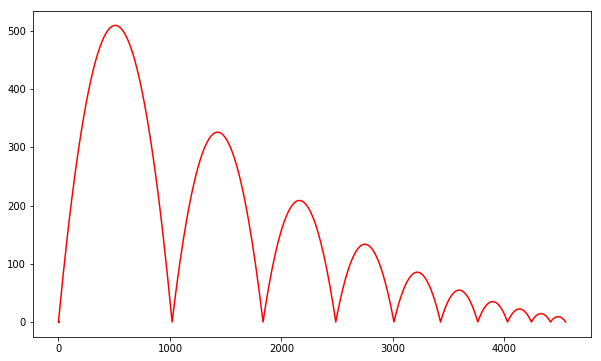

In [14]:
plt.figure(figsize=(10, 6))
#plt.plot(sol_smooth[0], sol_smooth[1], '-')
plt.plot(xvals,yvals, 'r-', fillstyle='none')
plt.hlines([0], 0, 10);

## 3. Van der Pol oscillator

The system for Van der Pol oscillator is given as:
$$
y_1' = y_2, \\
y_2' = \mu (1 - y_1^2) y_2 - y_1 \\
y_1(0) = 2, \quad y_2(0) = 0
$$
It becomes stiff for high values of $\mu$, meaning that regions of rapid transition are followed by regions where the solution varies slowly. Explicit methods either diverge or make prohibitevely many steps for stiff problems, thus implicit methods should be used. Our function `solve_ivp` implements a one-step fully implicit Runge-Kutta method of Radau II A family.

We solve this system for $\mu = 10^3$.

In [19]:
mu = 1e3

def fun(x, y):
    return [y[1], mu * (1 - y[0]**2) * y[1] - y[0]]

In [20]:
res = solve_ivp(fun, [0, 3000], [2, 0], method='Radau')

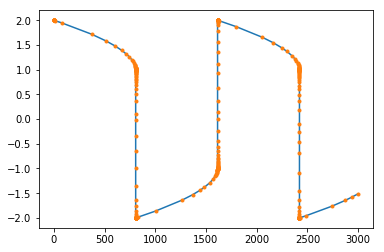

In [21]:
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[0], '.')

Note that the solver pass flat regions in very few number of steps. It would not be the case with any explicit method, which will have to make very small steps to overcome the stability issue. For example `method='RK45'` will make more than million steps on this example.

Cannon fired upward with terminal event upon impact. The ``terminal`` and 
    ``direction`` fields of an event are applied by monkey patching a function.
    Here ``y[0]`` is position and ``y[1]`` is velocity. The projectile starts at
    position 0 with velocity +10. Note that the integration never reaches t=100
    because the event is terminal.

In [18]:
def upward_cannon(t, y): return [y[1], -0.5]
def hit_ground(t, y): return y[1]
hit_ground.terminal = True
hit_ground.direction = -1
sol = solve_ivp(upward_cannon, [0, 100], [0, 10], events=hit_ground)
print(sol.t_events)
print(sol.t)
print(sol.y)


[array([ 20.])]
[  0.00000000e+00   9.99900010e-05   1.09989001e-03   1.10988901e-02
   1.11088891e-01   1.11098890e+00   1.11099890e+01   2.00000000e+01]
[[  0.00000000e+00   9.99897510e-04   1.09985977e-02   1.10958105e-01
    1.10780373e+00   1.08013149e+01   8.02419261e+01   1.00000000e+02]
 [  1.00000000e+01   9.99995000e+00   9.99945005e+00   9.99445055e+00
    9.94445555e+00   9.44450555e+00   4.44500550e+00   1.77635684e-15]]
